In [1]:
from network.examples import community, virus
from network.simulation import rv, test, run_simulations, create_runner
from network.randoms import fix_random
from network.graph import Graph

import random

import matplotlib.pyplot as plt
%matplotlib inline

In [21]:
n_communities = 800
community_size = 3
orphans = 800
total_ppl = n_communities * community_size + orphans

# assume 5 strong and weak connections per person
n_strong_conns = total_ppl * 5
n_weak_conns = total_ppl * 5

core_strength = 0.6
strong_strength = 0.15
p_strong_interact = 4 / 7
weak_strength = 0.03

def generate_graph():
    graph, node_community_map = community.community_graph(
        n_communities, community_size, orphans,
        n_strong_conns, n_weak_conns,
        core_kw={'strength': core_strength}, 
        strong_kw={'strength': strong_strength}, 
        weak_kw={'strength': weak_strength}
    )
    return graph

graph0 = generate_graph()

In [22]:
def reset_non_core_edges(transmission):
    graph = transmission.graph
    weak_edges_to_remove = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'weak']
    for prev_weak_edge in weak_edges_to_remove:
        graph.remove_edge(prev_weak_edge)
        
    strong_edges = [edge for edge in graph.iter_edges() if edge.attr('kind') == 'strong']

    n_new_weak_edges = len(weak_edges_to_remove)
    for new_weak_edge in community.generate_edges(graph, n_new_weak_edges):
        graph.add_edge(new_weak_edge, kind='weak', strength=weak_strength)
        
    for edge in strong_edges:
        new_strength = strong_strength if test(p_strong_interact) else 0
        graph.update_edge(edge, strength=new_strength)
        
no_mitigation = create_runner(before=reset_non_core_edges)

In [23]:
def enact_quarantine(transmission):
    graph = transmission.graph
    
    def should_remove_edge(edge):
        if edge.attr('kind') == 'strong' and test(0.75):
            return True
        if edge.attr('kind') == 'weak' and test(0.75):
            return True
        return False
    
    if not transmission.props.get('in_quarantine', False):
        transmission.props['in_quarantine'] = True
        edges_to_remove = [e for e in graph.iter_edges() if should_remove_edge(e)]
        for edge in edges_to_remove:
            graph.remove_edge(edge.nodes)
        
        
def put_on_masks(transmission, mask_factors=None, perc_masks=1.0):
    graph = transmission.graph
    if mask_factors is None:
        mask_factors = {
            'core': 1.0,
            'strong': 0.2,
            'weak': 0.2
        }
    for edge in graph.iter_edges():
        if test(perc_masks):
            graph.update_edge(edge.nodes, strength=mask_factors[edge.attr('kind')] * edge.attr('strength'))
                
                
def quarantine_and_mask(transmission):
    put_on_masks(transmission)
    enact_quarantine(transmission)
        
        
def runner_do_at(day, func):
    def before_func(transmission):
        reset_non_core_edges(transmission)
        if transmission.steps >= day:
            func(transmission)
    
    return create_runner(before=before_func)

In [24]:
def generate_sim(graph, runner):
    with fix_random():
        return virus.virus_simulation(
            graph=Graph.duplicate(graph),
            patient0=1,
            incubation_period=rv.randint(2, 14),
            contagious_for=rv.choice(0, 1, 2, 7),
            runner=runner
        )

In [25]:
action_day = 35

sim_control = generate_sim(graph0, runner=no_mitigation)
sim_quarantine = generate_sim(graph0, runner=runner_do_at(action_day, enact_quarantine))
sim_masks = generate_sim(graph0, runner=runner_do_at(action_day, put_on_masks))
sim_both = generate_sim(graph0, runner=runner_do_at(action_day, quarantine_and_mask))

In [26]:
results = run_simulations(
    sim_control,
    sim_quarantine,
    sim_masks,
    sim_both,
    to=120
)

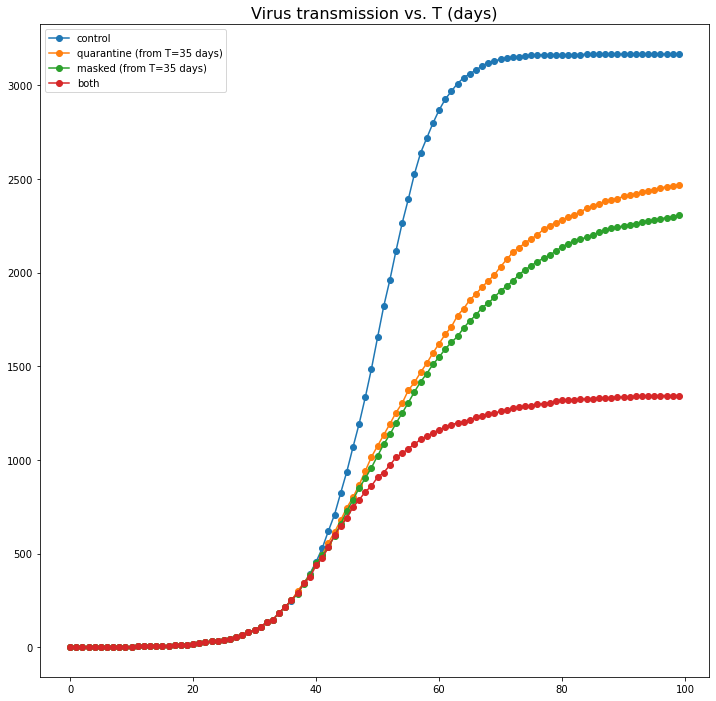

In [29]:
def sim_sequence(sim, n):
    for i in range(n):
        index = -1 if i >= len(sim.history) else i
        yield sim.history[index].broadcasts

fig = plt.figure(figsize=(12, 12))
plt.title('Virus transmission vs. T (days)', fontsize=16)
lines = []
for sim in results:
    line, = plt.plot(range(100), list(sim_sequence(sim, 100)), 'o-')
    lines.append(line)

plt.legend(
    lines, 
    ['control', f'quarantine (from T={action_day} days)', f'masked (from T={action_day} days)', 'both'], 
    loc='upper left'
)